In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

import missingno as msno
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: No module named 'missingno'

In [ ]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Download and extract the dataset

In [ ]:
train_dataset_path = 'realdw/Train.csv'
test_dataset_path = 'realdw/Test.csv'
raw_train_df = pd.read_csv(train_dataset_path)
raw_train_df.head()


In [ ]:
raw_test_df = pd.read_csv(test_dataset_path)
raw_test_df.head()
### Check data types of the column


In [ ]:
raw_train_df.dtypes

# Exploratory Data Analysis 

In [ ]:
# Assign class column name to a variable 
class_variable = "MALICIOUS_OFFENSE"

In [ ]:
raw_train_df.dtypes

# Covert "Date" column to datetime type and further extract the day and month.
    Intution: The number of hacks might be more on pay days or specific (bonus) months.

In [ ]:
raw_train_df['DATE'] = pd.to_datetime(raw_train_df['DATE'])
raw_train_df['day'] = raw_train_df['DATE'].dt.day
raw_train_df['month'] = raw_train_df['DATE'].dt.month

In [ ]:
# Drop DATE Column
raw_train_df.drop(columns=["DATE"],inplace=True)

In [ ]:
# Set INCIDENT_ID to index
raw_train_df= raw_train_df.set_index('INCIDENT_ID')

# Let's look at the variation of data across columns

In [ ]:
raw_train_df.describe()

### Insights

* The standard deviation of most of the variables is close to eachother and is not high. 
* Scaling is required since the variables are not of same scale.

In [ ]:
def missing_values_table(input_df):
    """
    Returns the number of missing values in each column (if it has any missing values) and percentage of missing values.

    Parameters
    ----------
    input_df: pd.DataFrame
        The dataframe that whose missing data information is required 

    Returns
    -------
    mis_val_table_ren_columns: pd.DataFrame
        Returns a dataframe containing columns and missing data information

    """
    # Total missing values
    mis_val = input_df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * input_df.isnull().sum() / len(input_df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Values Missing'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Values Missing', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(input_df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
train_missing= missing_values_table(raw_train_df)
train_missing

In [ ]:
test_missing= missing_values_table(raw_test_df)
test_missing

### Insights
* **Since the X_12 column has missing values in test, we cannot simply remove the missing rows in train set and continue modeling. We will have to deal with missing data in test too.**

### Let's Detect missing data visually using [Missingno](https://github.com/ResidentMario/missingno) library

In [7]:
msno.bar(raw_train_df)

NameError: name 'msno' is not defined

### Insights
* The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that X_12 column has missing values. Next,it would make sense to find out the locations of the missing data.


In [8]:
#sorted by X_12
sorted_df = raw_train_df.sort_values('X_12')
msno.matrix(sorted_df)

NameError: name 'raw_train_df' is not defined

### Insights
* We can see that the column has missing values towards higher values. Let's check what is the case with Test set.

In [9]:
#sorted by X_12
sorted_test_df = raw_test_df.sort_values('X_12')
msno.matrix(sorted_test_df)

NameError: name 'raw_test_df' is not defined

### Insights
* Test set also have similar missing values, so we can handle missing data in both in same way.


### K-Nearest Neighbor Imputation
* The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.

In [204]:
def impute_missing_data(input_df, columns):
    """
    Imputes the missing data in given column
    
    Parameters
    ----------
    input_df: pd.DataFrame
        The dataframe that whose column is to be imputed

    columns: list
        List containing names of the columns that needs to be imputed


    Returns
    -------
    result_df: pd.DataFrame
        Returns the dataframe with imputed values.
    """
    knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
    for column_name in columns:
        input_df[column_name] = knn_imputer.fit_transform(input_df[[column_name]])
    
    result_df = input_df.copy()

    return result_df

In [205]:
## We have missing data in X_12
train_df = impute_missing_data(raw_train_df, ['X_12'])

# Scaling Function <a name="scale"></a>

* Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [206]:
def scale_dataframe(input_df, columns):
    """
        Scales the given columns of input dataframe
        
        Parameters
        ----------
        input_df: pd.DataFrame
            The dataframe that has to be scaled
        
        columns: list
            List containing names of the columns that needs to be scaled
            
        
        Returns
        -------
        result_df: pd.DataFrame
            Returns the normalized dataframe.
    """
    scaler = StandardScaler()
    non_scale_columns = list(filter(lambda col : col not in columns, input_df.columns))
    normalized_df = pd.DataFrame(scaler.fit_transform(input_df[columns]), columns=columns)
    result_df = pd.concat(normalized_df, input_df[non_scale_columns])
    
    return result_df

In [207]:
# Correlation with all variables with MULTIPLE_OFFENSE
train_df.corr().nlargest(18, 'MALICIOUS_OFFENSE')['MALICIOUS_OFFENSE'].index

Index(['MALICIOUS_OFFENSE', 'X_11', 'X_15', 'X_1', 'month', 'X_13', 'day',
       'X_9', 'X_4', 'X_5', 'X_6', 'X_7', 'X_14', 'X_3', 'X_2', 'X_8', 'X_12',
       'X_10'],
      dtype='object')

## Correlation Plot <a name="corr"></a>

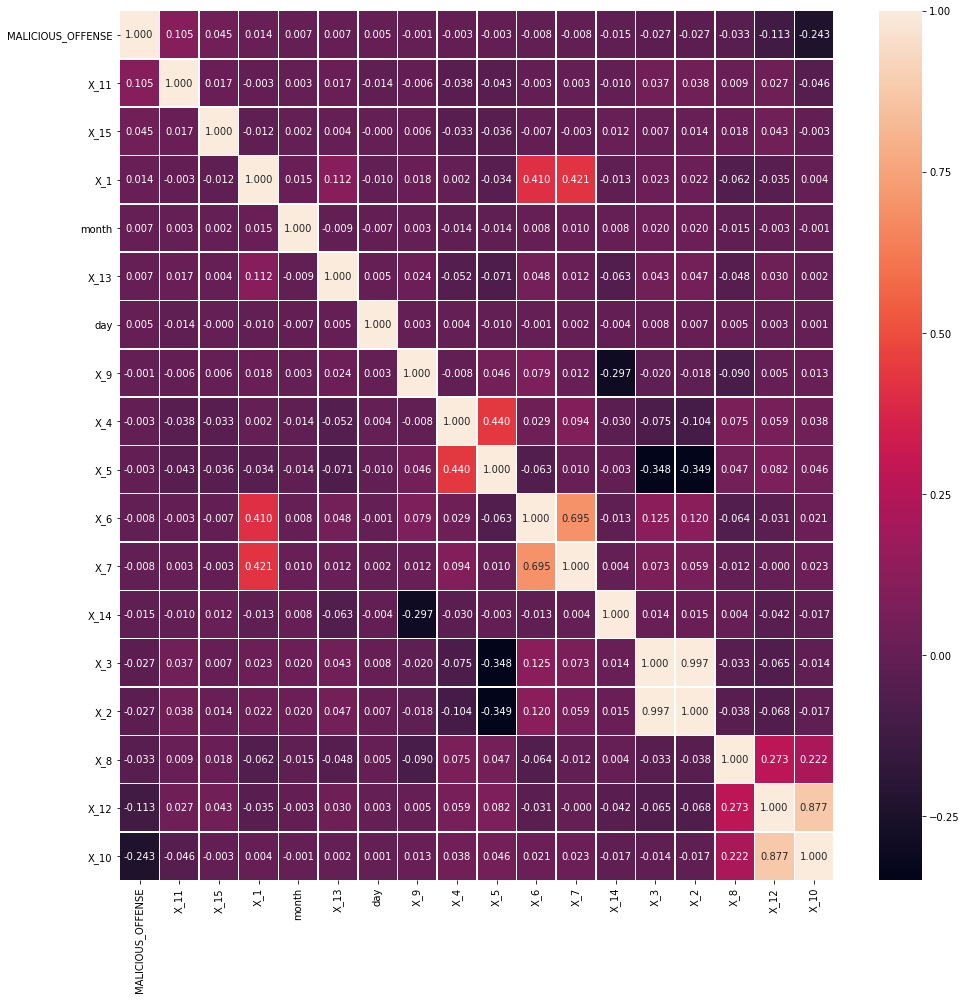

In [208]:
f,ax = plt.subplots(figsize=(16, 16))
high_to_low_col_index = train_df.corr().nlargest(19, class_variable)[class_variable].index
sns.heatmap(train_df[high_to_low_col_index].corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)

### Insights
* X_11 is most positvely correlated and X_10 is most neagatively correlated with MALICIOUS_OFFENSE respectively.
* Clearly X_2 and X_3 are almost same column.
* Furthuremore, (X_10, X_12) and (X_6, X_7) are also highly correlated respectively.

## Note:
* Decision trees are by nature immune to multi-collinearity. For example, if you have 2 features which are 99% correlated, when deciding upon a split the tree will choose only one of them. Other models such as Logistic regression would use both the features.Since boosted trees use individual decision trees, they also are unaffected by multi-collinearity.
* I did remove correlated columns using [Variation Inflation Factor](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) but didn't see any good improvement in recall_score so decided not to handle multicollinearity, XGBoost is doing that for me.

# Checking Class imbalance

In [209]:
neg, pos = np.bincount(train_df[class_variable])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100*neg/total))

Examples:
    Total: 23856
    Positive: 22788 (95.52% of total)
    Negative: 1068 (4.48% of total)



## Insights
* There is clear case of class imbalance.


## Note:
* Class imbalance is a serious problem for many classifiers since most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.
* Though ensemble tree models perform decently even when there is class imbalance I will be handling class imbalance here especially because this dataset is highly imbalanced.

In [210]:
X = train_df.loc[:, train_df.columns != class_variable]
Y = train_df.loc[:, train_df.columns == class_variable]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.33,random_state=8)

print('Training labels shape:', X_train.shape)
print('Test labels shape:', X_test.shape)
print('Training features shape:', y_train.shape)
print('Test features shape:', y_test.shape)

Training labels shape: (15983, 17)
Test labels shape: (7873, 17)
Training features shape: (15983, 1)
Test features shape: (7873, 1)


In [211]:
data = train_df

In [212]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MALICIOUS_OFFENSE,day,month
INCIDENT_ID,,,,,,,,,,,,,,,,,,
CR_102659,0,36,34,2,1,5,6,1,6,1,174,1.000,92,29,36,0,4,7
CR_189752,1,37,37,0,0,11,17,1,6,1,236,1.000,103,142,34,1,18,7
CR_184637,0,3,2,3,5,1,0,2,3,1,174,1.000,110,93,34,1,15,3
CR_139071,0,33,32,2,1,7,1,1,6,1,249,1.000,72,29,34,1,13,2
CR_109335,0,33,32,2,1,8,3,0,5,1,174,0.000,112,29,43,1,13,4


### Analysis and Visualizations

#### Class distribution

In [213]:
Malicious = data[data['MALICIOUS_OFFENSE'] == 1]
Non_Malicious = data[data['MALICIOUS_OFFENSE'] == 0]
Malicious_data = len(data[data['MALICIOUS_OFFENSE'] == 1])
NonMalicious_data = len(data[data['MALICIOUS_OFFENSE'] == 0])

#p = sns.barplot([0,1], [Malicious, Non_Malicious])
#p.set( xlabel = "To determine if Hacked (Malicious/NonMalicious)", ylabel = "Num of Users")

#### Time distribution

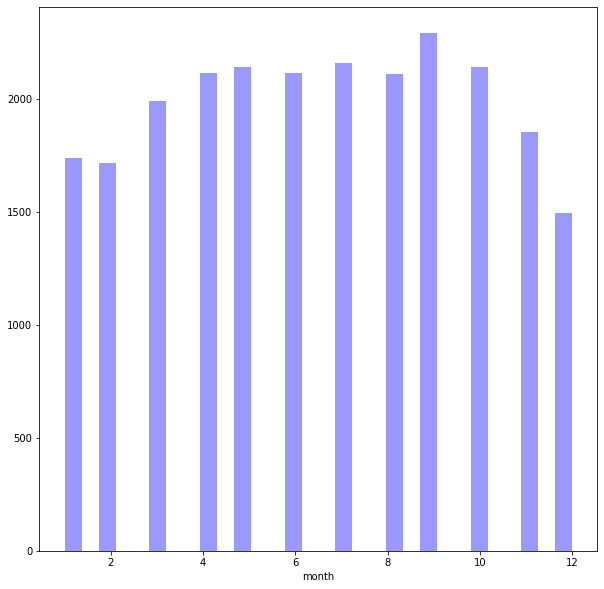

In [214]:
sns.distplot(data['month'], kde=False, color='blue', bins=30)

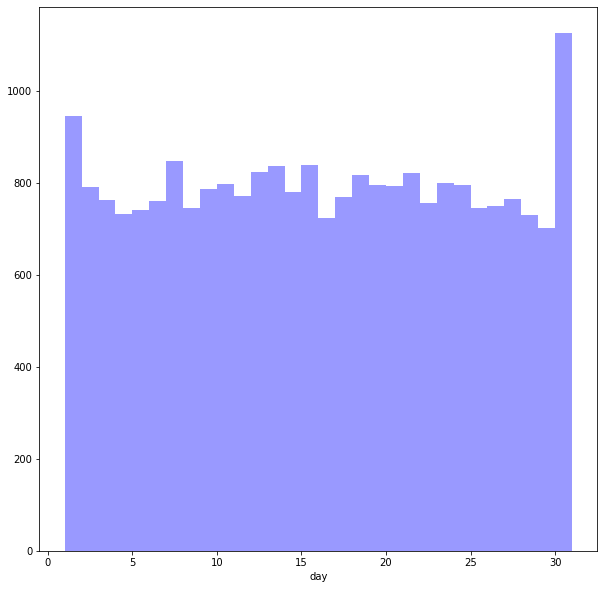

In [215]:
sns.distplot(data['day'], kde=False, color='blue', bins=30)

#### Distribution of time per class

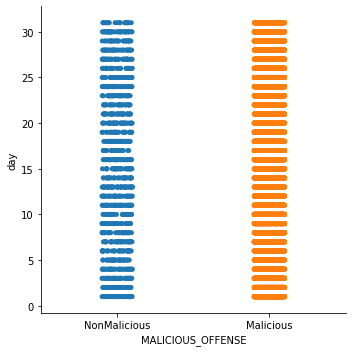

In [216]:
h = sns.catplot(x="MALICIOUS_OFFENSE", y="day", data=data)
h.set_xticklabels(['NonMalicious','Malicious'])

#### Feature corelation matrix

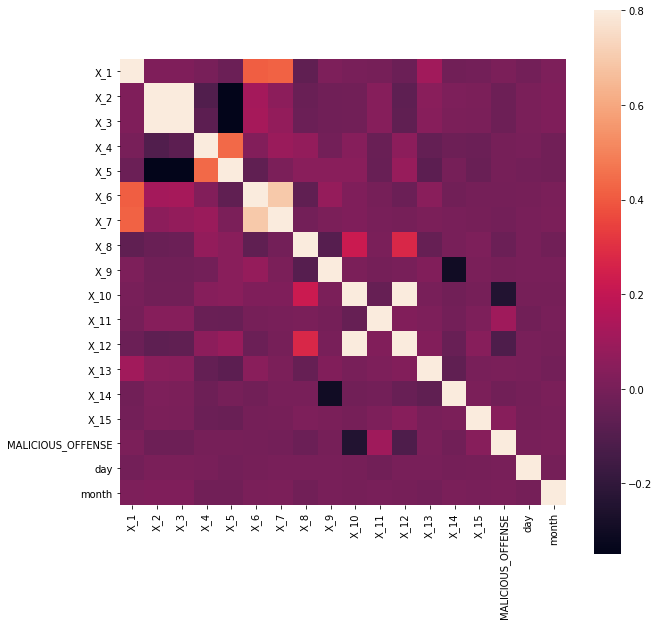

In [217]:
corrmat = data.corr()
fig = plt.figure()
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

#### Significant features

In [218]:
def ztest(feature):
    
    mean = NonMalicious[feature].mean()
    std = Malicious[feature].std()
    zScore = (Malicious[feature].mean() - mean) / (std/np.sqrt(sample_size)+ 1e-9 )
    
    return zScore

NonMalicious= data[data.MALICIOUS_OFFENSE==0]
Malicious= data[data.MALICIOUS_OFFENSE==1]
sample_size=len(Malicious)
significant_features=[]
critical_value=15

for i in data.columns[:-1]:
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

X_2  is statistically significant
X_3  is statistically significant
X_8  is statistically significant
X_10  is statistically significant
X_11  is statistically significant
X_12  is statistically significant
X_15  is statistically significant
MALICIOUS_OFFENSE  is statistically significant


# Preparing the data

In [219]:
X = train_df.loc[:, train_df.columns != class_variable]
Y = train_df.loc[:, train_df.columns == class_variable]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.33,random_state=8)

print('Training labels shape:', X_train.shape)
print('Test labels shape:', X_test.shape)
print('Training features shape:', y_train.shape)
print('Test features shape:', y_test.shape)

Training labels shape: (15983, 17)
Test labels shape: (7873, 17)
Training features shape: (15983, 1)
Test features shape: (7873, 1)


In [220]:
def generate_metrics(labels, predictions):
    """
        Calculates the metrics like accuracy, weighted recall, weighted precision
        and F1 score.
        
        Parameters
        ----------
        labels: 1d-array
            True values of the class variable
        
        predictions: 1d-array
            Predictions by the model
            
        
        Returns
        -------
        Does not return anything
    
    """
    ac = accuracy_score(labels,predictions)
    f_score = f1_score(labels,predictions)
    recall = recall_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    print('Accuracy is: ', ac)
    print('Recall is:', recall )
    print('Precision is:', precision)
    print('F1 score is: ', f_score)
    
def plot_roc(name, labels, predictions, **kwargs):
    """
        This helper function plots the receiver operating characteristic curve. One of the best metrics 
        to evaluate a model other than F1 score and Kappa score.
        
        Parameters
        ----------
        labels: 1d-array
            True values of the class variable
        
        predictions: 1d-array
            Predictions by the model
            
        
        Returns
        -------
        Does not return anything
    
    """
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_cm(labels, predictions, p=0.5):
    """
        This helper function plots the confusion matrix
        
        Parameters
        ----------
        labels: 1d-array
            True values of the class variable
        
        predictions: 1d-array
            Predictions by the model
        
        p: Float
            The thresold value
            
        
        Returns
        -------
        Does not return anything
    
    """
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [221]:
target_names = ['NonMalicious', 'Malicious']

### Logistic Regression Classifier

In [222]:
lr = LogisticRegression(random_state=0, max_iter=500, solver='liblinear').fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [223]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

NonMalicious       0.57      0.11      0.18       369
   Malicious       0.96      1.00      0.98      7504

    accuracy                           0.95      7873
   macro avg       0.76      0.55      0.58      7873
weighted avg       0.94      0.95      0.94      7873



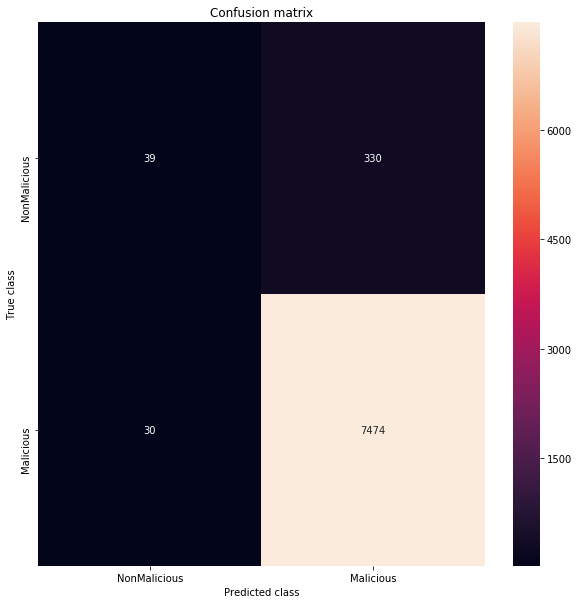

In [224]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels = target_names,
            yticklabels = target_names, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [225]:
metrics.accuracy_score(y_test, y_pred)

0.9542741013590753

In [226]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.8876357180416155

### Random Forest Classifier

In [227]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [228]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

NonMalicious       0.96      0.88      0.92       369
   Malicious       0.99      1.00      1.00      7504

    accuracy                           0.99      7873
   macro avg       0.98      0.94      0.96      7873
weighted avg       0.99      0.99      0.99      7873



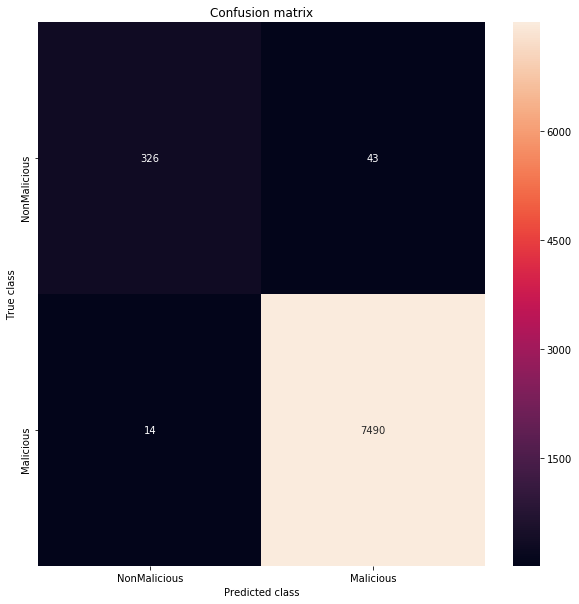

In [229]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels = target_names,
            yticklabels = target_names, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [230]:
metrics.accuracy_score(y_test, y_pred)

0.9927600660485203

In [231]:
roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

0.9988197803086774

### Linear SVM

In [232]:
svc = LinearSVC(max_iter=10000).fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [233]:
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

NonMalicious       0.59      0.04      0.07       369
   Malicious       0.95      1.00      0.98      7504

    accuracy                           0.95      7873
   macro avg       0.77      0.52      0.52      7873
weighted avg       0.94      0.95      0.93      7873



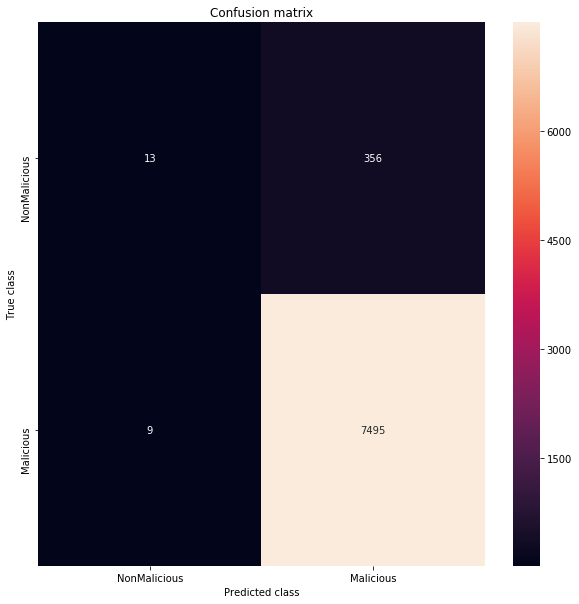

In [234]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels = target_names,
            yticklabels = target_names, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [235]:
metrics.accuracy_score(y_test, y_pred)

0.9536390194335069

In [236]:
roc_auc_score(y_test, svc.decision_function(X_test))

0.8414031035299692

### Artificial Neural Network

In [237]:
mlp = MLPClassifier().fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [238]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

NonMalicious       0.79      0.49      0.61       369
   Malicious       0.98      0.99      0.98      7504

    accuracy                           0.97      7873
   macro avg       0.88      0.74      0.80      7873
weighted avg       0.97      0.97      0.97      7873



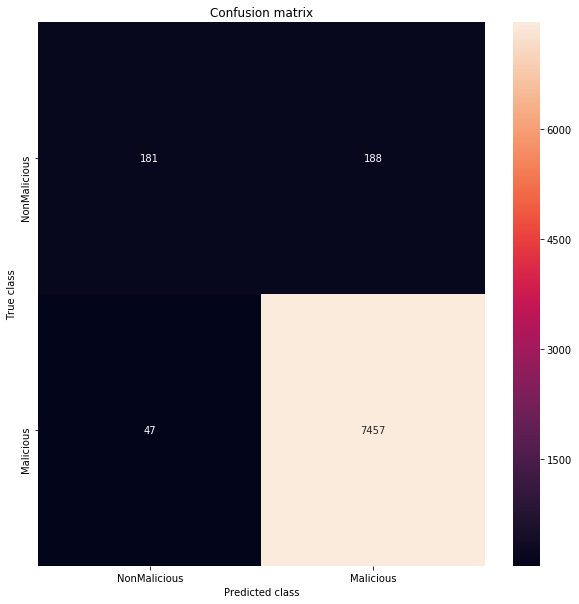

In [239]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels = target_names,
            yticklabels = target_names, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [240]:
metrics.accuracy_score(y_test, y_pred)

0.9701511494982853

In [241]:
roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

0.9528226319043573

### XGBoost

In [242]:
xgb = XGBClassifier().fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[11:13:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [243]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

NonMalicious       0.98      0.99      0.99       369
   Malicious       1.00      1.00      1.00      7504

    accuracy                           1.00      7873
   macro avg       0.99      0.99      0.99      7873
weighted avg       1.00      1.00      1.00      7873



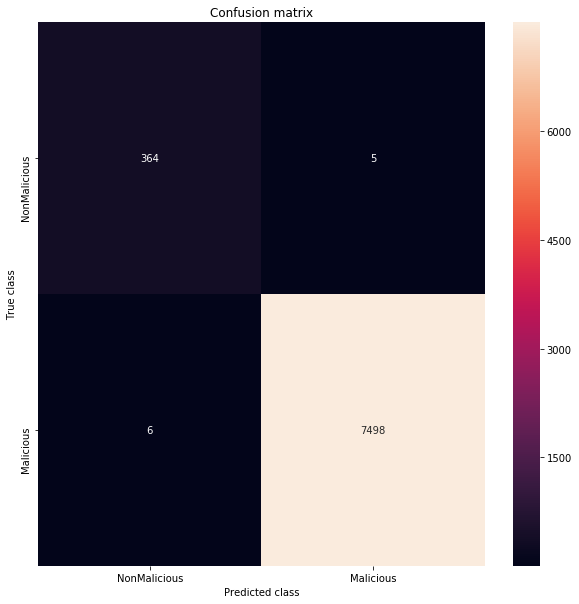

In [244]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels = target_names,
            yticklabels = target_names, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [245]:
metrics.accuracy_score(y_test, y_pred)

0.9986028197637495

In [246]:
roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

0.9992264288314524